In [1]:
from templates import *

/home/ubuntu/diffae/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# encode with trained model

## load model

In [2]:
device = 'cuda:0'
conf = ffhq128_autoenc_130M()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 122.58 M


## load EEG

In [3]:
import lmdb
import numpy as np
from PIL import Image
import pickle

In [ ]:
with open ("datasets/EEG_images.pickle","rb") as handle:
   EEG_images=pickle.load(handle)

with open ("datasets/EEG_labels.pickle","rb") as handle:
   EEG_labels=pickle.load(handle)

In [4]:
env = lmdb.open(
            'datasets/EEGtest.lmdb',
            max_readers=32,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False,
        )
index=10
with env.begin(write=False) as txn:
    # key = f'{self.original_resolution}-{str(index).zfill(self.zfill)}'.encode(
    #     'utf-8')
    key = f'data-{str(index).zfill(5)}'.encode('utf-8')

    img_bytes = txn.get(key)

data1 = pickle.loads(img_bytes)
# buffer = np.frombuffer(img_bytes).reshape((128,400))
# scaled_data = buffer * 1
EEG1 = data1["data"].astype(np.float32)


index=20
with env.begin(write=False) as txn:
    # key = f'{self.original_resolution}-{str(index).zfill(self.zfill)}'.encode(
    #     'utf-8')
    key = f'data-{str(index).zfill(5)}'.encode('utf-8')

    img_bytes = txn.get(key)

data2 = pickle.loads(img_bytes)
# buffer = np.frombuffer(img_bytes).reshape((128,400))
# scaled_data = buffer * 1
EEG2 = data2["data"].astype(np.float32)

In [5]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch_tree = data[0]['img'][None]
data_EEG= NumpyDataset([EEG1,EEG2])
batch_EEG1= data_EEG[0]['EEG'][None]
batch_EEG2= data_EEG[1]['EEG'][None]

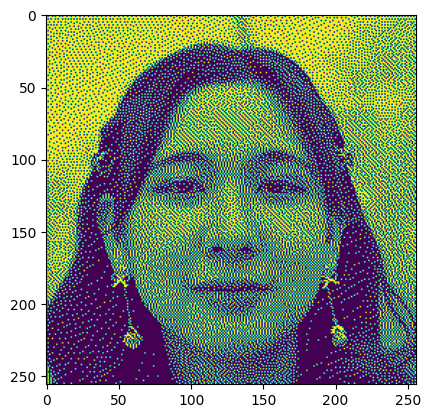

In [6]:
import matplotlib.pyplot as plt
plt.imshow(batch_tree[0].permute([1, 2, 0]) / 2 + 0.5)

## test

In [22]:
cond_eeg1 = model.encode(batch_EEG1.to(device))
xT_tree = model.encode_stochastic(batch_EEG1.to(device), cond_eeg1, T=250)

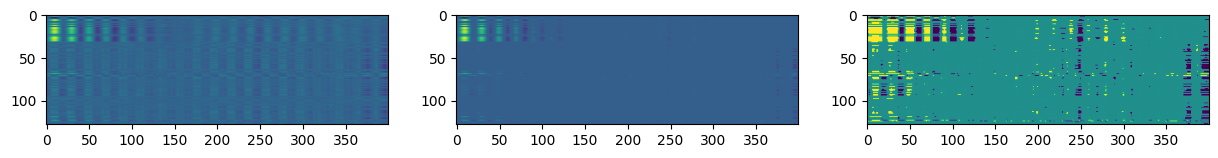

In [24]:
pred = model.render(xT_tree, cond_eeg1, T=20)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ori = (batch_EEG1 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_tree[0].permute(1, 2, 0).cpu())
ax[2].imshow(pred[0].permute(1, 2, 0).cpu())

In [19]:
cond_eeg1 = model.encode(batch_EEG1.to(device))
xT_tree = model.encode_stochastic(batch_tree.to(device), cond_eeg1, T=250)

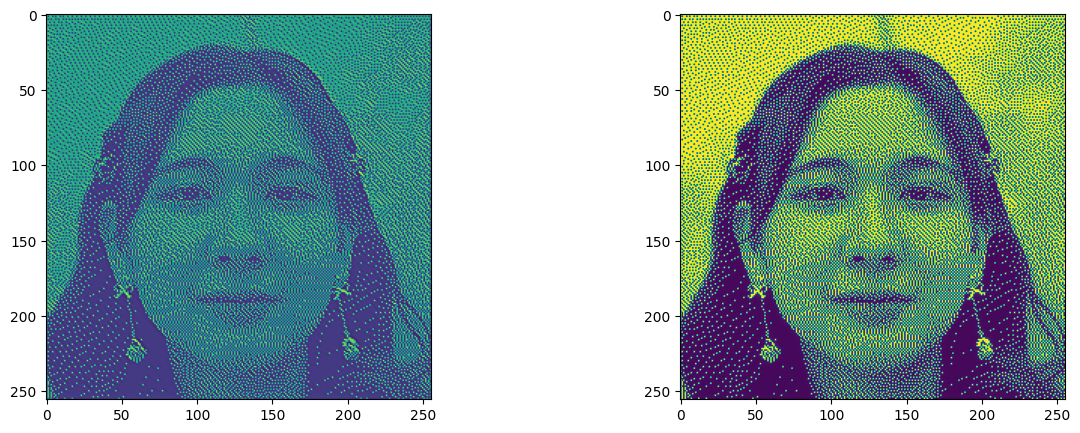

In [20]:
pred = model.render(xT_tree, cond_eeg1, T=20)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(xT_tree[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

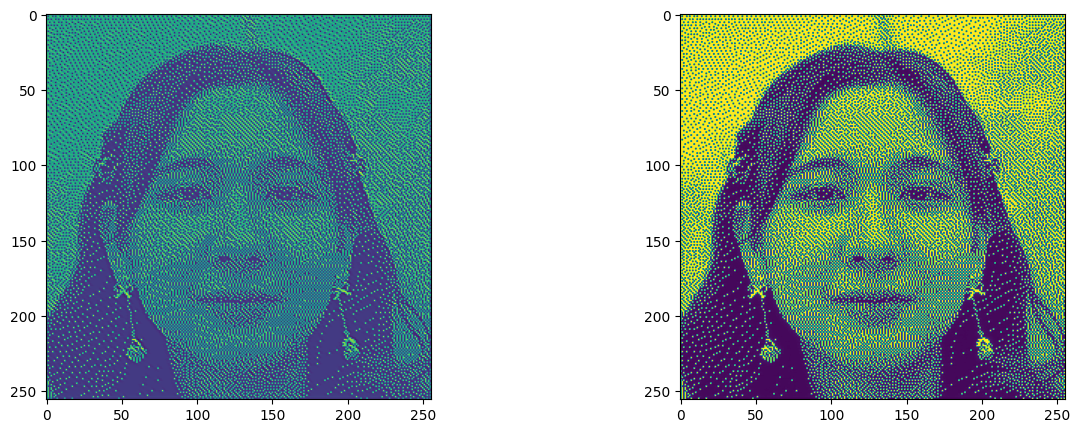

In [21]:
cond_eeg2 = model.encode(batch_EEG2.to(device))
pred = model.render(xT_tree, cond_eeg2, T=20)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(xT_tree[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

In [12]:
batch_EEG1

tensor([[[[-0.0600, -0.4018, -0.7612,  ...,  0.5611,  0.5337,  0.4587],
          [-0.0595, -0.4740, -0.9093,  ...,  0.3146,  0.2840,  0.2103],
          [ 0.1999,  1.1550,  2.1710,  ...,  0.7038,  0.5571,  0.3261],
          ...,
          [-0.1238, -0.6013, -0.8624,  ..., -2.3318, -1.8338, -1.3036],
          [-0.0112, -0.0354, -0.0487,  ..., -0.1220, -0.0996, -0.0751],
          [-0.0782, -0.4051, -0.6030,  ..., -1.4370, -1.1551, -0.8510]]]])

In [13]:
batch_EEG2

tensor([[[[-8.2662e-03,  1.6681e-01,  3.7382e-01,  ..., -4.0878e-01,
           -4.3878e-01, -4.5478e-01],
          [-1.4823e-02,  7.8089e-02,  2.1357e-01,  ..., -1.5286e-01,
           -1.6680e-01, -1.9250e-01],
          [ 5.4339e-02, -5.2776e-02, -2.7022e-01,  ..., -5.8319e-02,
           -1.7967e-01, -2.8325e-01],
          ...,
          [-1.3643e-01, -7.7941e-01, -9.1045e-01,  ..., -1.3074e-01,
           -3.8347e-02, -1.0322e-01],
          [-1.1728e-02, -3.9539e-02, -4.2817e-02,  ..., -4.9396e-03,
            1.4391e-03, -2.2617e-04],
          [-8.8723e-02, -4.8296e-01, -5.6378e-01,  ...,  4.2333e-03,
            3.9785e-02, -1.1370e-02]]]])

In [14]:
EEG1

array([[-0.0599811 , -0.40182254, -0.76119137, ...,  0.56110793,
         0.5336659 ,  0.4587348 ],
       [-0.05953627, -0.47404674, -0.9093082 , ...,  0.31456095,
         0.28403413,  0.21032019],
       [ 0.19991289,  1.1549932 ,  2.1710162 , ...,  0.7038309 ,
         0.5570858 ,  0.32614163],
       ...,
       [-0.12377562, -0.6013299 , -0.862399  , ..., -2.331841  ,
        -1.8338315 , -1.3035809 ],
       [-0.01115582, -0.03535172, -0.04871219, ..., -0.1220106 ,
        -0.09959491, -0.07511733],
       [-0.07820974, -0.40513408, -0.6029594 , ..., -1.4369764 ,
        -1.1551069 , -0.85101557]], dtype=float32)

In [15]:
cond_eeg2[0,:10]

tensor([-0.5952, -0.6786,  0.3783, -0.3697,  0.2394, -0.3299, -0.6183, -0.4944,
         0.1255, -0.6494], device='cuda:0')

In [16]:
cond_eeg1[0,:10]

tensor([-0.5608, -0.6315,  0.3675, -0.3431,  0.2194, -0.3263, -0.6098, -0.4560,
         0.1349, -0.5938], device='cuda:0')